In [2]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [3]:
import numpy as np 
from matplotlib import pyplot as plt

# This notebook is to find optimal dataset that maximize classifing equation value

In [4]:
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
kernel = Kernel('SingleQubit')
svm = BinarySVM(kernel, C=None, k=0.1, mutation='REDUCED_QASVM')

In [6]:
from scipy.optimize import minimize
def cost_fn(params, n=2):
    X = params.reshape(2*n, 2)
    # y = np.concatenate((np.zeros(n), np.ones(n)))
    y = np.ones(2*n)
    y[0]=0
    svm.fit(X, y)
    vector = svm.f(X)
    #return max(vector[0:n])-min(vector[n:2*n]) - sum(np.abs(svm.alpha)**2)
    return max([vector[0]])-min(vector[1:]) - sum(np.abs(svm.alpha)**2)
np.random.seed(None)
result = minimize(cost_fn, args=(2,), x0=np.random.randn(8), method='SLSQP', bounds=tuple(zip(-np.pi*np.ones(8), np.pi*np.ones(8))))

In [7]:
np.random.seed(42)
n=2
X = result.x.reshape(2*n, 2)
X = X + 0.1*np.random.randn(*X.shape)
y = np.array([0, 1, 1, 1])

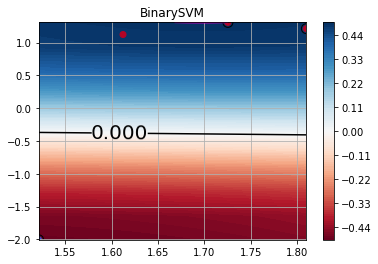

In [8]:
svm.fit(X, y)
from classifiers.visualization import Plot_SVM
Plot_SVM(svm).plot_boundary()

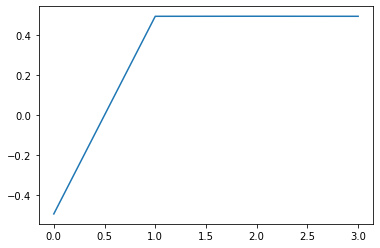

In [9]:
plt.plot(svm.f(X))

In [10]:
X

array([[ 1.52122222, -2.00528202],
       [ 1.7253286 ,  1.30938536],
       [ 1.61226076,  1.12382948],
       [ 1.80995737,  1.21355977]])

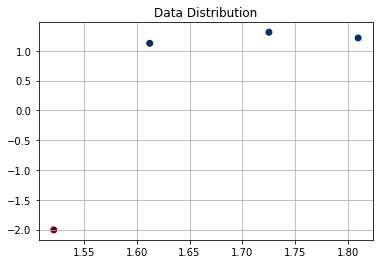

In [11]:
from classifiers.visualization import Plot_Data
Plot_Data(X, y).plot()

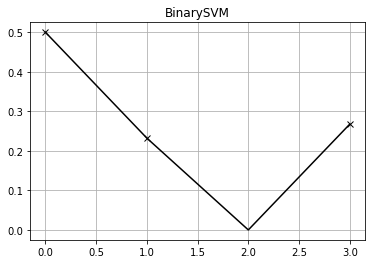

In [12]:
Plot_SVM(svm).plot('alpha')

# Now, let's run simulation

In [11]:
from classifiers.quantum.qasvm import BlochSphereQASVM
from classifiers.quantum._qasvm import  QASVM
from classifiers.visualization import Plot_Log_From_SPSA
from classifiers.utils import get_loggers_add_handle
from qiskit.aqua.components.optimizers import SPSA, SLSQP
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.aqua.algorithms.vq_algorithm import VQAlgorithm
from qiskit import IBMQ

In [12]:
'''
import dill
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
backend = QasmSimulator.from_backend(provider.get_backend('ibmq_manhattan'))
with open('/home/quic/QUIC-Projects/20210312_ibmq-manhattan.dill', 'wb') as f:
    dill.dump(backend, f)
    '''

"\nimport dill\nIBMQ.load_account()\nprovider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')\nbackend = QasmSimulator.from_backend(provider.get_backend('ibmq_manhattan'))\nwith open('/home/quic/QUIC-Projects/20210312_ibmq-manhattan.dill', 'wb') as f:\n    dill.dump(backend, f)\n    "

In [13]:
import dill
with open('/home/quic/QUIC-Projects/20210312_ibmq-manhattan.dill', 'rb') as f:
    backend = dill.load(f)
backend

QasmSimulator(
backend_name='qasm_simulator(ibmq_manhattan)',
    noise_model=<qiskit.providers.aer.noise.noise_model.NoiseModel object at 0x7f6050532670>)

In [14]:
'''
from qiskit.test.mock import FakeBoeblingen, FakeManhattan
backend = QasmSimulator.from_backend(FakeManhattan())
backend'''

'\nfrom qiskit.test.mock import FakeBoeblingen, FakeManhattan\nbackend = QasmSimulator.from_backend(FakeManhattan())\nbackend'

In [15]:
quantum_instance = QuantumInstance(backend=backend, shots=2**13, optimization_level=3, seed_transpiler=0, measurement_error_mitigation_cls=CompleteMeasFitter)
del quantum_instance.qjob_config['wait']
optimizer = SPSA(maxiter=2**5, last_avg=2**2)
var_form = RealAmplitudes(2, reps=5)
qasvm = BlochSphereQASVM(X, y, var_form=var_form, optimizer=optimizer, quantum_instance=quantum_instance, C=None, k=0.1).dual
qc = qasvm.second_order_circuit[0]
print(qc.depth())
qc.draw(idle_wires=False, fold=-1)


187


global phase: -975.487262055209
              ┌────┐   ┌──────────────┐   ┌────┐   ┌───────┐                        ┌───┐                                                                                                                                                                                                                                                                                        ┌───┐                                                                                                                                                                                                                                                     ┌───┐                    ┌───┐                                                  ┌───┐                                                        ┌───┐                              ┌───┐                                ┌───┐                                                                                                                                                                                                                                                                                                                                                      ┌───┐     ┌────┐┌───────┐┌───────┐  ┌────┐ ┌──────────┐  ┌────┐  ┌────────┐                                                 ┌──────────┐┌────┐┌──────────┐┌────┐ ┌────────┐       ┌────────┐┌────┐┌──────────┐  ┌────┐        ┌──────────┐                                        ┌───┐                                                                                                            ┌───┐                                                                           ┌───┐             ┌──────────┐   ┌────┐   ┌─────────┐                  ░          
  i_0 -> 1 ───┤ √X ├───┤ RZ(θ[0] + π) ├───┤ √X ├───┤ RZ(π) ├───────────■────────────┤ X ├──■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ X ├──■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ X ├──■─────────■───────┤ X ├───────■────────────────────────────────────■─────┤ X ├───────■────────────────────────────────────────■───────┤ X ├──■───────────────────■───────┤ X ├──■────────────────────■────────┤ X ├──■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────■──┤ X ├──■──┤ √X ├┤ RZ(π) ├┤ RZ(π) ├──┤ √X ├─┤ RZ(3π/2) ├──┤ √X ├──┤ RZ(4π) ├────────────────────────────────────────────■────┤ RZ(3π/2) ├┤ √X ├┤ RZ(3π/2) ├┤ √X ├─┤ RZ(3π) ├───■───┤ RZ(-π) ├┤ √X ├┤ RZ(3π/2) ├──┤ √X ├────────┤ RZ(5π/2) ├──────────────────────────────────■─────┤ X ├──────■────────────────────────────────────────────────────────────────────────────────────────■────────────┤ X ├────────────■────────────────────────────────────────────────────────■─────┤ X ├──────■──────┤ RZ(3π/4) ├───┤ √X ├───┤ RZ(π/2) ├──■───────────────░──────────
              ├────┤   └┬────────────┬┘   ├────┤   ├───────┤         ┌─┴─┐          └─┬─┘┌─┴─┐            ┌───┐                                ┌────┐┌──────────────┐┌────┐┌───────┐     ┌────┐┌──────────────┐┌────┐┌───────┐     ┌────┐┌──────────────┐┌────┐┌───────┐     ┌────┐┌──────────────┐┌────┐┌───────┐     ┌────┐┌───────────────┐┌────┐┌───────┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐  ┌───────┐   ┌────┐┌──────────┐ ┌───────┐ ┌────┐       ┌───────┐        ┌────┐┌────────┐     ┌──────────┐┌────┐┌──────────┐┌────┐ 

In [16]:
qasvm

QASVM (qiskit)
	type: Dual
	backend: qasm_simulator(ibmq_manhattan)
	error mitigation: <class 'qiskit.ignis.mitigation.measurement.fitters.CompleteMeasFitter'>
	(C, k): (None, 0.1)
	accuracy: None

In [17]:
logger = get_loggers_add_handle(optimizer, VQAlgorithm, QASVM)[0]
qasvm.run()

{'optimizer_evals': None,
 'optimizer_time': 39.96591877937317,
 'optimal_value': 0.2861868789290817,
 'optimal_point': array([-2.67503477, -1.57427373, -3.29880323,  1.1810553 , -2.94282357,
        -0.07435951,  2.64856184,  0.62767038,  0.41914213,  2.44696073,
        -4.34335315,  0.14992287]),
 'optimal_parameters': {Parameter(θ[0]): -2.675034769110108,
  Parameter(θ[1]): -1.574273728349661,
  Parameter(θ[2]): -3.2988032285289304,
  Parameter(θ[3]): 1.1810552969071204,
  Parameter(θ[4]): -2.942823568384239,
  Parameter(θ[5]): -0.0743595067423257,
  Parameter(θ[6]): 2.648561837977105,
  Parameter(θ[7]): 0.6276703787979898,
  Parameter(θ[8]): 0.41914212888572855,
  Parameter(θ[9]): 2.44696073019868,
  Parameter(θ[10]): -4.343353150747893,
  Parameter(θ[11]): 0.1499228728863103}}

In [22]:
import dill
with open(logger.handlers[-1].baseFilename.split('.')[0]+'.pkl', 'wb') as f:
    dill.dump(qasvm, f)

# End Session

# Restart Session

In [1]:
import sys
import pathlib
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)
import dill
p = pathlib.Path.home()/'QUIC-Projects'/'exp_logs'
#dill.load_session(max(p.glob('*.dill'), key=lambda p: p.stat().st_ctime))
files = sorted(p.glob('*.dill'), key=lambda p: p.stat().st_ctime, reverse=True)
log_files = sorted(p.glob('*.log'), key=lambda p: p.stat().st_ctime, reverse=True)
file_index = 3
dill.load_session(files[file_index])
exp_log = log_files[file_index]


/home/quic/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [23]:
print(qasvm)
print(qasvm.quantum_instance.run_config)
print(qasvm.optimizer.setting)
print(svm)

QASVM (qiskit)
	type: Dual
	backend: qasm_simulator(ibmq_manhattan)
	error mitigation: <class 'qiskit.ignis.mitigation.measurement.fitters.CompleteMeasFitter'>
	(C, k): (None, 0.1)
	accuracy: 0.5
RunConfig(max_credits=10, shots=8192)
Optimizer: SPSA
-- gradient_support_level: 1
-- bounds_support_level: 1
-- initial_point_support_level: 3
-- options: {'save_steps': 1, 'last_avg': 4}
-- max_evals_grouped: 1
-- maxiter: 32
-- parameters: [0.38398682 0.1        0.602      0.101      0.        ]
-- skip_calibration: False

BinarySVM: (REDUCED_QASVM)
	Kernel: SingleQubit
	HyperParameter: None
	Optimization Status: optimal
	Iterations: 5



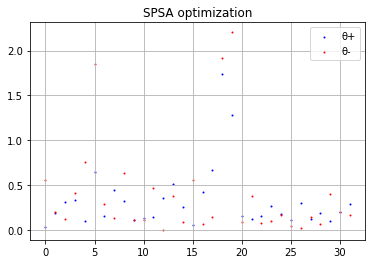

In [25]:
Plot_Log_From_SPSA(logger.handlers[-1].baseFilename.split('.')[0]+'.log').plot(min_step=0, max_step=np.inf)

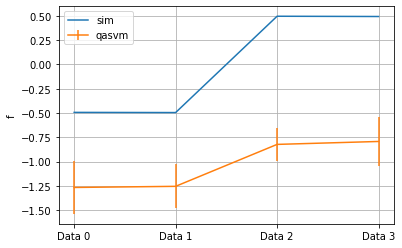

In [26]:
plt.plot(svm.f(X), label='sim')
res = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(len(res.mean(axis=0))), res.mean(axis=0), yerr=2*res.std(axis=0), label='qasvm')
plt.xticks(range(4), [f'Data {i}' for i in range(4)])
plt.ylabel('f')
plt.legend()
plt.grid()

In [ ]:
from classifiers.utils import clean_exp_logs
clean_exp_logs()

In [ ]:
from qiskit import __qiskit_version__
__qiskit_version__